# WaveUnet

In [10]:
# Installation des dépendances manquantes pour le notebook Wave_UNet
#!pip install librosa tqdm soundfile numpy
#!pip install matplotlib

In [11]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import glob
import random
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm 

from IPython.display import Audio, display

# Synthèse : Wave-U-Net (Stoller et al., 2018)

### 1. Motivations : Pourquoi le Domaine Temporel ?
L'approche classique basée sur les spectrogrammes (STFT) est limitée par :
* **La perte de la Phase :** L'information temporelle précise est souvent ignorée, rendant la reconstruction audio imparfaite (son métallique).
* **Hyperparamètres Fixes :** La transformation de Fourier impose des choix arbitraires (taille de fenêtre) non optimisés par le réseau.
* **Objectif :** Traiter directement la **forme d'onde brute (Raw Audio)** pour apprendre conjointement l'amplitude et la phase.

### 2. Innovations Architecturales
Le modèle est un **U-Net 1D** avec des adaptations spécifiques pour éviter les artefacts sonores :

* **A. Upsampling par Interpolation Linéaire**
    * *Problème :* La "Transposed Convolution" classique crée des artefacts haute fréquence (bruits périodiques).
    * *Solution :* Remplacer par une **Interpolation Linéaire** (lissage simple) suivie d'une convolution standard.
    
* **B. Proper Input Context (Contexte Valide)**
    * *Problème :* Le "Zero Padding" (ajout de zéros) aux bords du signal fausse les prédictions aux extrémités.
    * *Solution :* **Entrée > Sortie**. Le réseau reçoit un contexte plus large que ce qu'il doit prédire. Les bords sont ainsi calculés avec de vraies données voisines, pas du silence artificiel.

### 3. Résultats
* **Performance :** Le Wave-U-Net obtient des résultats **comparables à l'état de l'art** (U-Net sur spectrogrammes) pour la séparation de la voix chantée.
* **Observation Critique :** Les auteurs soulignent que la métrique standard (**SDR**) est instable sur les silences. Ils recommandent l'utilisation de la **Médiane** plutôt que la Moyenne pour évaluer les modèles.

### 4. Conclusion
* Le papier valide l'efficacité de la séparation **End-to-End** sur le signal brut.
* Il démontre que le réseau peut capter le **contexte temporel à long terme** nécessaire à la séparation, sans passer par une transformation en image (spectrogramme).

![Texte alternatif](WaveUnet.png)

In [ ]:
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=15):
        super().__init__()
        # Convolution avec stride=2 pour réduire la taille par 2 (équivalent décimage intelligent, permet d'éviter le maxpooling qui perd l'information temporelle)
        self.conv = nn.Conv1d(
            in_channels, out_channels, 
            kernel_size=kernel_size, 
            stride=2, 
            padding=kernel_size//2
        )
        self.act = nn.LeakyReLU(0.1)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(self.act(self.conv(x)))

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        # Interpolation linéaire pour agrandir + Convolution
        self.conv = nn.Conv1d(
            in_channels, out_channels, 
            kernel_size=kernel_size, 
            stride=1, 
            padding=kernel_size//2
        )
        self.act = nn.LeakyReLU(0.1)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x, skip_connection):
        # 1. Upsample (Interpolation linéaire, évite la transposed convolution qui peut créer des artefacts en damier, créant des perturbations audios. Pour l'audio l'interpolation linéaire est plus douce)
        x = F.interpolate(x, scale_factor=2, mode='linear', align_corners=False)
        
        # 2. Gestion des petits décalages de taille (padding) : 
        if x.shape[-1] != skip_connection.shape[-1]:
            diff = skip_connection.shape[-1] - x.shape[-1]
            x = F.pad(x, (0, diff))
            
        # 3. Concaténation (Skip Connection)
        x = torch.cat([x, skip_connection], dim=1)
        
        # 4. Convolution finale
        return self.bn(self.act(self.conv(x)))


# Fonction de perte SI-SDR négatif
#MSE dans le papier, mais ici on utilise le SI-SDR négatif pour de meilleures performances, 
# car le si sdr est invariant à l'échelle et se concentre davantage sur la forme du signal.
class NegSISDR(nn.Module): 
        def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, estimate, target):
        # S'assurer qu'on compare bien la voix (canal 0) à la voix
        # Si estimate est (Batch, 2, Time), on peut vouloir optimiser la somme des SDR
        # ou juste la voix. Ici, exemple général pour (Batch, C, T)
        
        # 1. Produit scalaire <x, y>
        dot = torch.sum(estimate * target, dim=-1, keepdim=True)
        
        # 2. Norme de la cible ||y||^2, c'est le facteur d'échelle qui rend le SI-SDR invariant à l'échelle
        ref_energy = torch.sum(target ** 2, dim=-1, keepdim=True) + self.eps
        
        # 3. Projection optimale (Target scalée)
        projected = (dot / ref_energy) * target
        
        # 4. Bruit (Noise) ie erreur de reconstruction
        noise = estimate - projected
        
        # 5. Ratios énergies
        ratio = torch.sum(projected ** 2, dim=-1) / (torch.sum(noise ** 2, dim=-1) + self.eps)
        
        # 6. SI-SDR en dB
        si_sdr = 10 * torch.log10(ratio + self.eps)
        
        # 7. On veut maximiser le SDR, donc minimiser son négatif
        return -torch.mean(si_sdr)

class WaveUNet(nn.Module):
    def __init__(self, num_levels=5, base_channels=24): # Limitation mémoire GPU, on ne peut pas mettre trop de canaux de base. Le papier conseillait 12 
        super().__init__()
        
        self.levels = num_levels
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        
        # --- Encoder (Descente) ---
        in_ch = 1 
        out_ch = base_channels
        self.skip_channels_history = []
        
        for _ in range(num_levels):
            self.down_blocks.append(DownSamplingBlock(in_ch, out_ch))
            self.skip_channels_history.append(in_ch)
            in_ch = out_ch
            out_ch *= 2 
            
        # --- Bottleneck ---
        self.bottleneck = nn.Conv1d(in_ch, out_ch, kernel_size=15, stride=1, padding=7) # stride = 1 pour ne pas réduire la taille temporelle ici, juste une retraite d'information
        self.bottleneck_act = nn.LeakyReLU(0.1)
        
        # --- Decoder (Remontée) ---
        in_ch = out_ch 
        
        for i in range(num_levels):
            # On récupère la taille du skip
            skip_ch = self.skip_channels_history[-(i+1)]
            
            # --- CORRECTION ICI ---
            if i == num_levels - 1:
                # Si c'est le DERNIER bloc, on ne veut pas redescendre à 1 canal.
                # On veut sortir 'base_channels' (24) pour nourrir la final_conv.
                out_ch = base_channels
            else:
                # Sinon, on redescend normalement à la taille du skip
                out_ch = skip_ch
            
            self.up_blocks.append(UpSamplingBlock(in_ch + skip_ch, out_ch))
            in_ch = out_ch
            
        # --- Sortie ---
        # Attend base_channels (24) en entrée
        self.final_conv = nn.Conv1d(base_channels, 2, kernel_size=1, stride=1)
        
    def forward(self, x):
        skips = []
        
        # Encoder
        for block in self.down_blocks:
            skips.append(x)
            x = block(x)
            
        # Bottleneck
        x = self.bottleneck_act(self.bottleneck(x))
        
        # Decoder
        for i, block in enumerate(self.up_blocks):
            skip = skips[-(i+1)]
            x = block(x, skip)
            
        out = torch.tanh(self.final_conv(x))
        return out

### Définition Mathématique du SI-SDR

Le **SI-SDR** (Scale-Invariant Signal-to-Distortion Ratio) est une métrique qui évalue la qualité de la séparation audio en étant insensible aux différences de volume (gain) entre l'estimation et la cible.

Soit $s$ le signal cible (vérité terrain) et $\hat{s}$ le signal estimé par le réseau. On décompose l'estimation en deux composantes orthogonales :

1.  **La composante cible mise à l'échelle ($s_{\text{target}}$)** :
    On cherche le scalaire $\alpha$ qui projette l'estimation sur la cible :
    $$\alpha = \frac{\langle \hat{s}, s \rangle}{\|s\|^2} \quad \text{et} \quad s_{\text{target}} = \alpha \cdot s$$

2.  **L'erreur résiduelle ($e_{\text{noise}}$)** :
    C'est la partie du signal qui ne correspond pas à la cible (distorsions + artefacts) :
    $$e_{\text{noise}} = \hat{s} - s_{\text{target}}$$

**Formule finale (en dB) :**
Le SI-SDR est le ratio logarithmique entre l'énergie du signal utile et l'énergie de l'erreur :

$$\text{SI-SDR} = 10 \log_{10} \left( \frac{\| s_{\text{target}} \|^2}{\| e_{\text{noise}} \|^2} \right)$$

*Note : Pour l'entraînement, on minimise l'opposé de cette valeur (NegSI-SDR).*

In [ ]:
class WaveformDataset(Dataset):
    def __init__(self, base_dir, sample_rate=16000, segment_length=16384):
        self.base_dir = base_dir
        self.sr = sample_rate
        self.segment_length = segment_length
        # On récupère tous les dossiers 0001, 0002...
        self.folders = sorted(glob.glob(os.path.join(base_dir, "*")))
        
    def __len__(self):
        return len(self.folders)
    
    def __getitem__(self, idx):
        folder = self.folders[idx]
        
        # 1. Charger les fichiers
        # On cherche le fichier mix (peu importe le SNR)
        mix_path = glob.glob(os.path.join(folder, "mix_snr_*.wav"))[0]
        voice_path = os.path.join(folder, "voice.wav")
        noise_path = os.path.join(folder, "noise.wav")
        
        mix, _ = librosa.load(mix_path, sr=self.sr)
        voice, _ = librosa.load(voice_path, sr=self.sr)
        noise, _ = librosa.load(noise_path, sr=self.sr)
        
        # 2. Découpage aléatoire (Random Crop)
        # On prend un extrait de 'segment_length'
        if len(mix) > self.segment_length:
            start = random.randint(0, len(mix) - self.segment_length)
            end = start + self.segment_length
            mix = mix[start:end]
            voice = voice[start:end]
            noise = noise[start:end]
        else:
            # Si trop court, on pad avec des zéros
            pad_len = self.segment_length - len(mix)
            mix = np.pad(mix, (0, pad_len))
            voice = np.pad(voice, (0, pad_len))
            noise = np.pad(noise, (0, pad_len))
            
        # 3. Format PyTorch (Channel, Time) -> (1, T)
        mix = torch.FloatTensor(mix).unsqueeze(0)
        # Target: (2, T) -> Canal 0: Voix, Canal 1: Bruit
        targets = np.stack([voice, noise]) 
        targets = torch.FloatTensor(targets)
        
        return mix, targets

In [14]:
def train_wave_unet(train_loader, val_loader, epochs=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")
    
    model = WaveUNet(num_levels=5, base_channels=24).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = NegSISDR() # MAE est souvent meilleur que MSE pour l'audio brut
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        batch_loss = 0
        
        for mix, target in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            mix, target = mix.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(mix) # Output shape: (Batch, 2, Time)
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            batch_loss += loss.item()
            
        train_losses.append(batch_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for mix, target in val_loader:
                mix, target = mix.to(device), target.to(device)
                output = model(mix)
                val_loss += criterion(output, target).item()
        
        val_losses.append(val_loss / len(val_loader))
        print(f"Loss Train: {train_losses[-1]:.4f} | Loss Val: {val_losses[-1]:.4f}")
        
    return model, train_losses, val_losses

# --- LANCEMENT ---



from torch.utils.data import random_split

# 1. Création du Dataset complet
full_train_dataset = WaveformDataset("train/", sample_rate=16000)

# 2. Calcul des tailles (ex: 80% train, 20% validation)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# 3. Split aléatoire
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

# 4. DataLoaders séparés
dataloader_train = DataLoader(train_subset, batch_size=16, shuffle=True)
dataloader_val = DataLoader(val_subset, batch_size=16, shuffle=False)

# Maintenant vous pouvez lancer train_wave_unet(dataloader_train, dataloader_val, ...)

model, t_loss, v_loss = train_wave_unet(dataloader_train, dataloader_val, epochs=30)

Training on cuda


Epoch 1:   2%|▏         | 5/250 [00:01<00:56,  4.33it/s]

Epoch 1: 100%|██████████| 250/250 [00:56<00:00,  4.44it/s]


Loss Train: 0.4466 | Loss Val: -0.7966


Epoch 2: 100%|██████████| 250/250 [00:50<00:00,  4.95it/s]


Loss Train: -1.9122 | Loss Val: -3.2540


Epoch 3: 100%|██████████| 250/250 [00:55<00:00,  4.53it/s]


Loss Train: -3.1873 | Loss Val: -3.6571


Epoch 4: 100%|██████████| 250/250 [00:53<00:00,  4.68it/s]


Loss Train: -3.4007 | Loss Val: -4.2341


Epoch 5: 100%|██████████| 250/250 [00:53<00:00,  4.72it/s]


Loss Train: -2.9046 | Loss Val: -4.4588


Epoch 6: 100%|██████████| 250/250 [00:53<00:00,  4.64it/s]


Loss Train: -4.0859 | Loss Val: -4.8241


Epoch 7: 100%|██████████| 250/250 [00:52<00:00,  4.72it/s]


Loss Train: -3.8136 | Loss Val: -2.9435


Epoch 8: 100%|██████████| 250/250 [00:51<00:00,  4.83it/s]


Loss Train: -4.0509 | Loss Val: -5.1892


Epoch 9: 100%|██████████| 250/250 [00:54<00:00,  4.58it/s]


Loss Train: -5.1976 | Loss Val: -5.3523


Epoch 10: 100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


Loss Train: -4.4968 | Loss Val: -5.4706


Epoch 11: 100%|██████████| 250/250 [00:52<00:00,  4.80it/s]


Loss Train: -4.9547 | Loss Val: -5.4745


Epoch 12: 100%|██████████| 250/250 [00:53<00:00,  4.64it/s]


Loss Train: -5.5078 | Loss Val: -5.5989


Epoch 13: 100%|██████████| 250/250 [00:52<00:00,  4.74it/s]


Loss Train: -4.8265 | Loss Val: -5.7512


Epoch 14: 100%|██████████| 250/250 [00:56<00:00,  4.44it/s]


Loss Train: -4.9643 | Loss Val: -5.3898


Epoch 15: 100%|██████████| 250/250 [00:55<00:00,  4.54it/s]


Loss Train: -5.4993 | Loss Val: -6.2357


Epoch 16: 100%|██████████| 250/250 [00:54<00:00,  4.56it/s]


Loss Train: -5.6622 | Loss Val: -6.2393


Epoch 17: 100%|██████████| 250/250 [00:50<00:00,  4.95it/s]


Loss Train: -5.4843 | Loss Val: -6.1400


Epoch 18: 100%|██████████| 250/250 [00:50<00:00,  4.92it/s]


Loss Train: -6.3599 | Loss Val: -6.8647


Epoch 19: 100%|██████████| 250/250 [00:53<00:00,  4.71it/s]


Loss Train: -6.2787 | Loss Val: -5.5256


Epoch 20: 100%|██████████| 250/250 [00:50<00:00,  4.99it/s]


Loss Train: -5.5975 | Loss Val: -5.3837


Epoch 21: 100%|██████████| 250/250 [00:53<00:00,  4.71it/s]


Loss Train: -6.2413 | Loss Val: -5.9040


Epoch 22: 100%|██████████| 250/250 [00:51<00:00,  4.82it/s]


Loss Train: -6.1321 | Loss Val: -6.5411


Epoch 23: 100%|██████████| 250/250 [00:51<00:00,  4.86it/s]


Loss Train: -6.3400 | Loss Val: -7.0168


Epoch 24: 100%|██████████| 250/250 [00:52<00:00,  4.80it/s]


Loss Train: -6.6486 | Loss Val: -6.7604


Epoch 25: 100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


Loss Train: -6.5030 | Loss Val: -7.1554


Epoch 26: 100%|██████████| 250/250 [00:51<00:00,  4.85it/s]


Loss Train: -5.9675 | Loss Val: -7.1645


Epoch 27: 100%|██████████| 250/250 [00:50<00:00,  4.91it/s]


Loss Train: -6.2882 | Loss Val: -6.9026


Epoch 28: 100%|██████████| 250/250 [00:49<00:00,  5.07it/s]


Loss Train: -6.8454 | Loss Val: -7.6423


Epoch 29: 100%|██████████| 250/250 [00:49<00:00,  5.03it/s]


Loss Train: -6.6304 | Loss Val: -6.9421


Epoch 30: 100%|██████████| 250/250 [00:53<00:00,  4.71it/s]


Loss Train: -6.8477 | Loss Val: -7.4813


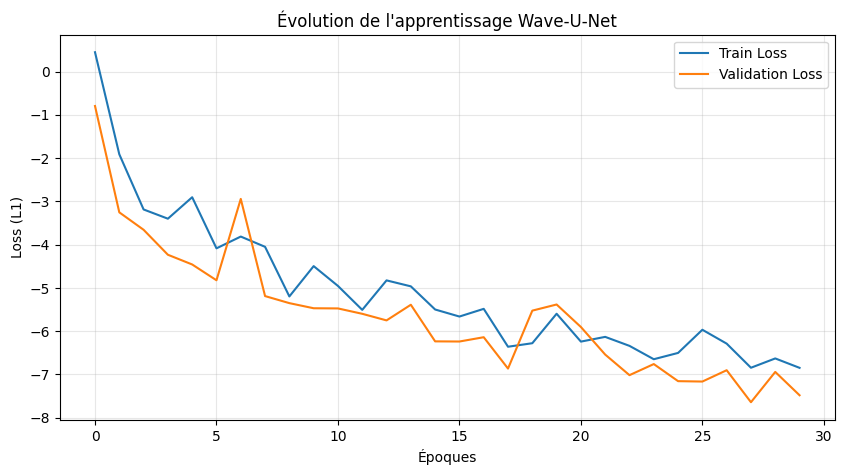

In [15]:
def plot_loss_curve(train_losses, val_losses):
    """Affiche les courbes de loss d'entraînement et de validation."""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Époques')
    plt.ylabel('Loss (L1)')
    plt.title('Évolution de l\'apprentissage Wave-U-Net')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 1. Afficher la courbe de loss (utilisez les variables retournées par train_wave_unet)
if 't_loss' in locals() and 'v_loss' in locals():
    plot_loss_curve(t_loss, v_loss)

In [ ]:


def calculate_si_sdr(reference, estimation):
    """
    Calcule le SI-SDR (Scale-Invariant Signal-to-Distortion Ratio)
    """
    # Alignement des tailles (par sécurité)
    min_len = min(len(reference), len(estimation))
    reference = reference[:min_len]
    estimation = estimation[:min_len]
    
    # Éviter la division par zéro
    eps = 1e-8
    
    # Projection du signal estimé sur la référence
    dot_product = np.dot(reference, estimation)
    norm_ref = np.linalg.norm(reference)**2
    projection = (dot_product / (norm_ref + eps)) * reference
    
    # Le bruit est la partie orthogonale
    noise = estimation - projection
    
    # Calcul du ratio en dB
    numerator = np.linalg.norm(projection)**2
    denominator = np.linalg.norm(noise)**2
    si_sdr = 10 * np.log10(numerator / (denominator + eps))
    
    return si_sdr

def evaluate_on_test_set(model, test_root_dir="test/"):
    """
    Évalue le modèle sur TOUS les dossiers contenus dans test_root_dir.
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Récupérer tous les sous-dossiers (0001, 0002, etc.) dans 'test/'
    test_folders = sorted(glob.glob(os.path.join(test_root_dir, "*")))
    
    if len(test_folders) == 0:
        print(f"Attention : Aucun dossier trouvé dans {test_root_dir}")
        return
        
    si_sdr_scores = []
    
    print(f"Début de l'évaluation sur {len(test_folders)} fichiers de test...")
    
    with torch.no_grad(): # Pas de gradient pour l'inférence (économie mémoire)
        for folder in tqdm(test_folders):
            # 1. Trouver les fichiers
            mix_files = glob.glob(os.path.join(folder, "mix_snr_*.wav"))
            if not mix_files:
                continue # On saute si dossier vide
                
            mix_path = mix_files[0]
            voice_path = os.path.join(folder, "voice.wav")
            
            # 2. Chargement Audio
            # On charge tout le fichier (sr=16000 pour Wave-U-Net)
            mix, sr = librosa.load(mix_path, sr=16000) 
            voice_true, _ = librosa.load(voice_path, sr=16000)
            #On peut faire passer un fichier de n'importe quelle longueur au modèle puisqu'il ne s'agit que de convolutions
            
            # 3. Préparation Tenseur
            # Shape: (Batch=1, Channel=1, Time=N)
            input_tensor = torch.FloatTensor(mix).unsqueeze(0).unsqueeze(0).to(device)
            
            # 4. Prédiction Wave-U-Net
            prediction = model(input_tensor)
            
            # 5. Récupération Voix (Canal 0)
            # On repasse sur CPU et en Numpy
            voice_est = prediction[0, 0, :].cpu().numpy() # bien que la target soit un stack de voice et bruit, on ne s'intéresse qu'à la voix pour le calcul du sdr
            
            # 6. Score
            score = calculate_si_sdr(voice_true, voice_est)
            si_sdr_scores.append(score)

    # Statistiques Finales
    mean_score = np.mean(si_sdr_scores)
    median_score = np.median(si_sdr_scores)
    
    print("-" * 30)
    print(f"RÉSULTATS SUR LE JEU DE TEST ({len(si_sdr_scores)} fichiers)")
    print(f"SI-SDR Moyen   : {mean_score:.2f} dB")
    print(f"SI-SDR Médian  : {median_score:.2f} dB")
    print(f"SI-SDR Min     : {np.min(si_sdr_scores):.2f} dB")
    print(f"SI-SDR Max     : {np.max(si_sdr_scores):.2f} dB")
    print("-" * 30)
    
    return si_sdr_scores

# --- LANCEMENT DE L'ÉVALUATION ---
# Assurez-vous que votre modèle est entraîné avant de lancer ceci !
scores = evaluate_on_test_set(model, test_root_dir="test/")

Début de l'évaluation sur 2000 fichiers de test...


100%|██████████| 2000/2000 [01:03<00:00, 31.52it/s]

------------------------------
RÉSULTATS SUR LE JEU DE TEST (2000 fichiers)
SI-SDR Moyen   : 8.76 dB
SI-SDR Médian  : 9.32 dB
SI-SDR Min     : -2.45 dB
SI-SDR Max     : 13.46 dB
------------------------------


In [18]:
#Evaluation sur train

scores = evaluate_on_test_set(model, test_root_dir="train/")

Début de l'évaluation sur 5000 fichiers de test...


100%|██████████| 5000/5000 [02:32<00:00, 32.73it/s]

------------------------------
RÉSULTATS SUR LE JEU DE TEST (5000 fichiers)
SI-SDR Moyen   : 8.45 dB
SI-SDR Médian  : 8.87 dB
SI-SDR Min     : -1.24 dB
SI-SDR Max     : 13.49 dB
------------------------------


📂 Fichier chargé : train/0753/mix_snr_0.wav


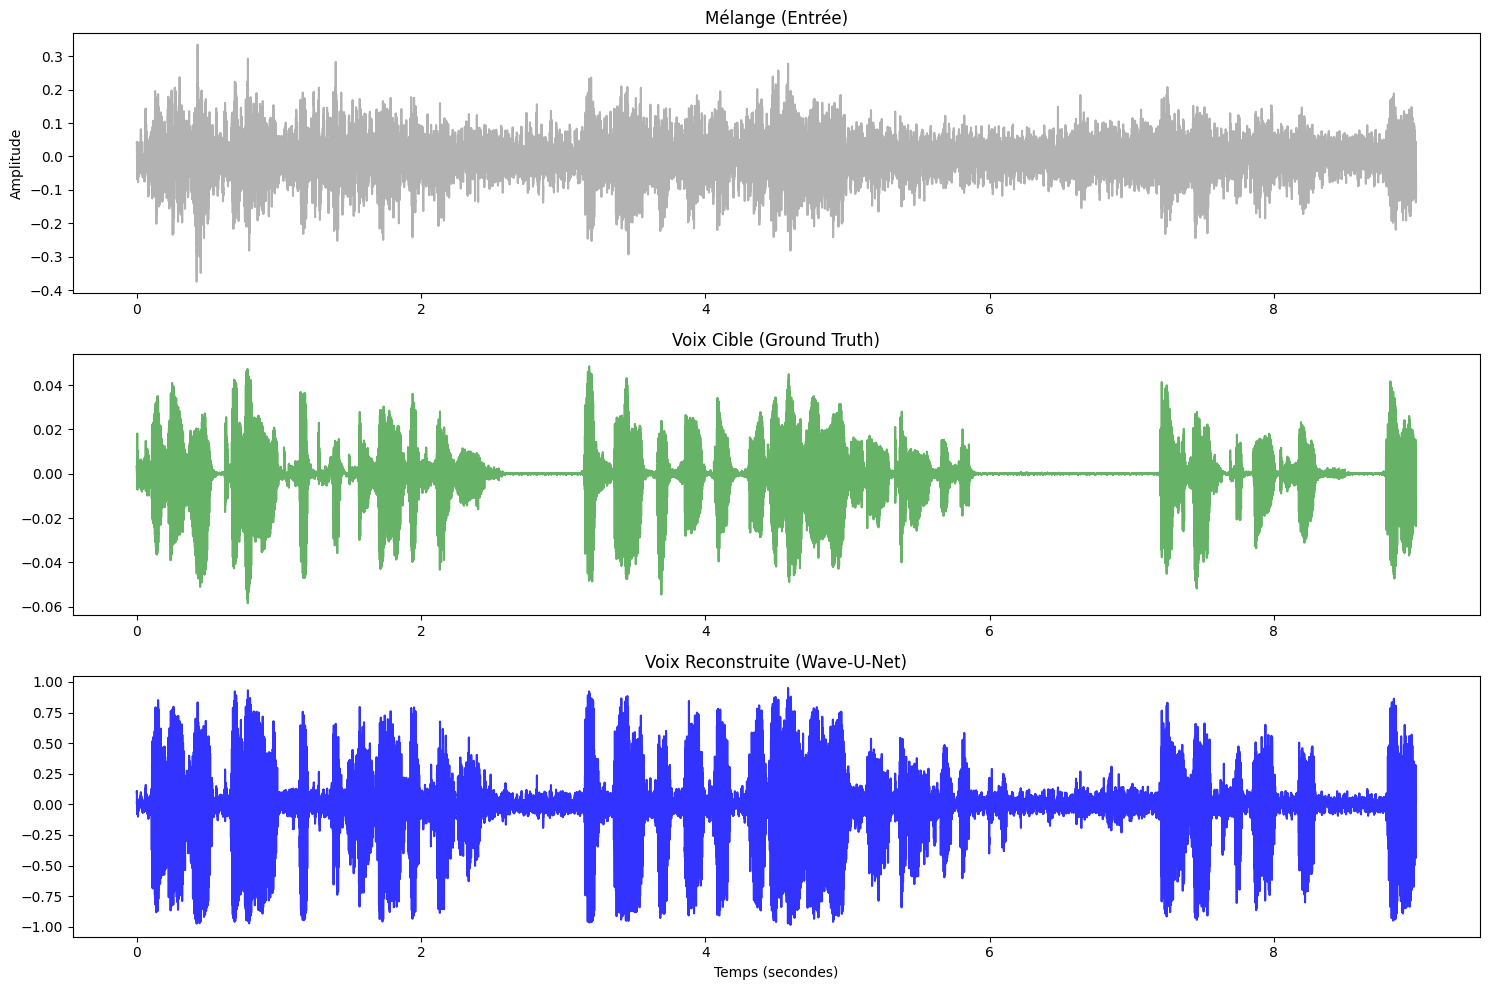

------------------------------
🎧 ÉCOUTE (9.0 secondes) :

1. Mélange original :



2. Voix Cible :



3. Voix Reconstruite :


------------------------------


In [ ]:
from IPython.display import Audio, display

def visualize_long_sample(model, test_folder="test/", duration=9.0, sr=16000, device='cpu'):
    """
    Charge un fichier audio réel du dossier test, prend un extrait de 'duration' secondes,
    et applique le modèle dessus.
    """
    model.eval()
    
    # 1. Trouver un dossier au hasard dans le dossier test (ou val)
    # Si vous n'avez pas de dossier "test", mettez "train" ici pour essayer
    folders = sorted(glob.glob(os.path.join(test_folder, "*")))
    if not folders:
        print(f"Erreur: Aucun dossier trouvé dans '{test_folder}'")
        return

    random_folder = random.choice(folders)
    
    # Chemins des fichiers
    # Adapter le pattern si vos fichiers s'appellent différemment
    mix_path = glob.glob(os.path.join(random_folder, "mix_snr_*.wav"))[0]
    voice_path = os.path.join(random_folder, "voice.wav")
    
    print(f"Fichier chargé : {mix_path}")
    
    # 2. Charger l'audio (duration = 9 secondes)
    # librosa charge en (Time,)
    mix, _ = librosa.load(mix_path, sr=sr, duration=duration)
    voice_true, _ = librosa.load(voice_path, sr=sr, duration=duration)
    
    # Assurer que les longueurs correspondent (si le fichier est plus court que 9s)
    min_len = min(len(mix), len(voice_true))
    mix = mix[:min_len]
    voice_true = voice_true[:min_len]
    
    # 3. Préparer pour PyTorch
    # Shape nécessaire : (Batch=1, Channel=1, Time)
    mix_tensor = torch.FloatTensor(mix).unsqueeze(0).unsqueeze(0).to(device)
    
    # 4. Inférence
    with torch.no_grad():
        prediction = model(mix_tensor)
        
    # 5. Récupérer le résultat (Voix estimée)
    voice_est = prediction[0, 0, :].cpu().numpy()
    
    # --- VISUALISATION ---
    plt.figure(figsize=(15, 10))
    time_axis = np.linspace(0, len(mix)/sr, len(mix))
    
    # Mix
    plt.subplot(3, 1, 1)
    plt.title("Mélange (Entrée)")
    plt.plot(time_axis, mix, color='gray', alpha=0.6)
    plt.ylabel("Amplitude")
    
    # Target
    plt.subplot(3, 1, 2)
    plt.title("Voix Cible (Ground Truth)")
    plt.plot(time_axis, voice_true, color='green', alpha=0.6)
    
    # Prediction
    plt.subplot(3, 1, 3)
    plt.title("Voix Reconstruite (Wave-U-Net)")
    plt.plot(time_axis, voice_est, color='blue', alpha=0.8)
    plt.xlabel("Temps (secondes)")
    
    plt.tight_layout()
    plt.show()
    
    # --- AUDIO ---
    print("-" * 30)
    print(f"🎧 ÉCOUTE ({len(mix)/sr:.1f} secondes) :")
    
    print("\n1. Mélange original :")
    display(Audio(mix, rate=sr))
    
    print("\n2. Voix Cible :")
    display(Audio(voice_true, rate=sr))
    
    print("\n3. Voix Reconstruite :")
    display(Audio(voice_est, rate=sr))
    print("-" * 30)

# --- LANCEMENT ---
# Remplacez "train/" par votre dossier contenant les sons (ex: "train/" ou "test/")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lancez ceci autant de fois que vous voulez pour tester différents fichiers
visualize_long_sample(model, test_folder="train/", duration=9.0, device=device)

In [1]:
import os
import glob
import numpy as np
print(f"Version chargée : {np.__version__}")
import librosa
from tqdm import tqdm

def calculate_si_sdr_numpy(reference, estimation):
    """
    Calcule le SI-SDR (Scale-Invariant Signal-to-Distortion Ratio) avec Numpy.
    reference : Le signal propre (Voix)
    estimation : Le signal à évaluer (Ici, le Mélange)
    """
    # Alignement des tailles
    min_len = min(len(reference), len(estimation))
    reference = reference[:min_len]
    estimation = estimation[:min_len]
    
    eps = 1e-8
    
    # Projection du signal estimé sur la référence
    # Alpha = <x, s> / ||s||^2
    dot_product = np.dot(estimation, reference)
    norm_ref = np.linalg.norm(reference)**2 + eps
    alpha = dot_product / norm_ref
    
    target_scaled = alpha * reference
    
    # Bruit résiduel
    noise = estimation - target_scaled
    
    # Ratio énergies
    ratio = np.linalg.norm(target_scaled)**2 / (np.linalg.norm(noise)**2 + eps)
    si_sdr = 10 * np.log10(ratio + eps)
    
    return si_sdr

def evaluate_baseline_mix(test_root_dir="test/"):
    """
    Parcourt le dossier de test et calcule le SI-SDR entre le MIX et la VOIX.
    C'est la performance "sans rien faire".
    """
    # Récupération des dossiers
    test_folders = sorted(glob.glob(os.path.join(test_root_dir, "*")))
    
    if len(test_folders) == 0:
        print(f"❌ Erreur : Aucun dossier trouvé dans '{test_root_dir}'. Vérifiez le chemin.")
        return

    baseline_scores = []
    
    print(f"📊 Calcul de la baseline sur {len(test_folders)} fichiers...")
    
    for folder in tqdm(test_folders):
        # 1. Trouver les fichiers
        mix_files = glob.glob(os.path.join(folder, "mix_snr_*.wav"))
        voice_path = os.path.join(folder, "voice.wav")
        
        if not mix_files or not os.path.exists(voice_path):
            continue
            
        mix_path = mix_files[0]
        
        # 2. Chargement (SR doit correspondre à celui de vos données, ex: 16000)
        try:
            mix, _ = librosa.load(mix_path, sr=16000)
            voice, _ = librosa.load(voice_path, sr=16000)
            
            # 3. Calcul du score "Mix vs Voix"
            score = calculate_si_sdr_numpy(voice, mix)
            baseline_scores.append(score)
            
        except Exception as e:
            print(f"Erreur sur {folder}: {e}")

    if not baseline_scores:
        print("Aucun score calculé.")
        return

    # Statistiques
    mean_score = np.mean(baseline_scores)
    
    print("\n" + "="*40)
    print(" RÉSULTATS BASELINE (Mélange non traité)")
    print("="*40)
    print(f"SI-SDR Moyen  : {mean_score:.2f} dB")
    print(f"SI-SDR Médian : {np.median(baseline_scores):.2f} dB")
    print(f"SI-SDR Min    : {np.min(baseline_scores):.2f} dB")
    print(f"SI-SDR Max    : {np.max(baseline_scores):.2f} dB")
    print("="*40)

# --- LANCEMENT ---
# Vérifiez bien que "test/" est le bon chemin vers vos dossiers
evaluate_baseline_mix(test_root_dir="test/")

Version chargée : 2.3.5
📊 Calcul de la baseline sur 2000 fichiers...


100%|██████████| 2000/2000 [00:54<00:00, 36.57it/s] 


 RÉSULTATS BASELINE (Mélange non traité)
SI-SDR Moyen  : -0.05 dB
SI-SDR Médian : -0.09 dB
SI-SDR Min    : -5.18 dB
SI-SDR Max    : 5.00 dB
